# Predicting FSTE Share Prices - Advanced Data Science Capstone Project

## RAMESH KUMAR SHARMA

#### <font color=red> Note: All elements of the project are contained within this SINGLE notebook

***

## Extract Transform Load

### Data Import

#### Data Source: Yahoo Finance; FSTE 100 Index Jan 1984 - Aug 2020

In [157]:
# Import key libraries and dataset

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

In [164]:
# The code was removed by Watson Studio for sharing.

In [165]:
df_data_1 = pd.read_csv(body)
df_data_1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Jan 03, 1984",997.5,1001.4,997.5,997.5,997.5,-
1,"Jan 04, 1984",997.5,999.5,993.3,998.6,998.6,-
2,"Jan 05, 1984",1007.1,1015.8,1007.1,1015.8,1015.8,-
3,"Jan 06, 1984",1019,1029.3,1019,1029,1029,-
4,"Jan 09, 1984",1030.6,1035.4,1030.6,1034.6,1034.6,-


In [31]:
df_data_1.shape

(9432, 7)

***

## Feature Engineering

In [32]:
# Interested in the daily 'Close' price of this dataset, so can drop the other columns
df_data_2 = df_data_1.drop(['Open','High','Low','Adj Close','Volume'], axis=1)
df_data_2.head()

,Date,Close
0,"Jan 03, 1984",997.5
1,"Jan 04, 1984",998.6
2,"Jan 05, 1984",1015.8
3,"Jan 06, 1984",1029
4,"Jan 09, 1984",1034.6


#### Data Quality Assessment

In [33]:
# Tidy up the data by removing rows where there is a '-' ie no data entry eg. public holidays.

df_data_3 = df_data_2[df_data_2.Close != "-"]
print(df_data_3.shape)

(9317, 2)


In [34]:
# Investigate the type of data in each column
df_data_3.dtypes

Date     object
Close    object
dtype: object

In [35]:
df_data_3.head()

,Date,Close
0,"Jan 03, 1984",997.5
1,"Jan 04, 1984",998.6
2,"Jan 05, 1984",1015.8
3,"Jan 06, 1984",1029
4,"Jan 09, 1984",1034.6


In [38]:
# Convert our primary data column 'Close' to float
df_data_3.Close = df_data_3.Close.astype(float)
df_data_3.dtypes

Date      object
Close    float64
dtype: object

#### Data Exploration

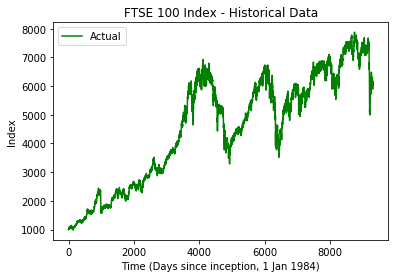

In [62]:
# Initial Data Visualisation

import matplotlib.pyplot as plt

df_data_3_plot = df_data_3.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df_data_3_plot, color = 'green', label = 'Actual')
plt.title('FTSE 100 Index - Historical Data')
plt.xlabel('Time (Days since inception, 1 Jan 1984)')
plt.ylabel('Index')
plt.legend()
plt.show()

In [103]:
# Determine training set size - ie. modulo zero, given batch_size 128 as starting point (TO BE ITERATED)

batch_size = 128


def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))


length = get_train_length(df_data_3, batch_size, 0.1)
print(length)

8320
8320


In [104]:
# Add timesteps * 2
# Use 14 timesteps - will provide a FORTNIGHT window of historic data on which to predict the following fortnight
# Create a single feature dataset for training

timesteps = 14

upper_train = length + timesteps*2
df_data_3_train = df_data_3[0:upper_train]
training_set = df_data_3_train.iloc[:,1:2].values
training_set.shape

(8348, 1)

In [105]:
# Feature Scaling - between zero to 1

from sklearn.preprocessing import MinMaxScaler
import numpy as np

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(8348, 1)

In [106]:
# Create training set arrays

X_train = []
y_train = []

# Data structure with 14 timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#14 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#14 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

8334
8320
8320
[array([0.00173285, 0.00191267, 0.00472446, 0.00688235, 0.00779781,
       0.00774877, 0.00596688, 0.00725834, 0.00912197, 0.00966144,
       0.00899119, 0.01173759, 0.01159046, 0.01178663]), array([0.00191267, 0.00472446, 0.00688235, 0.00779781, 0.00774877,
       0.00596688, 0.00725834, 0.00912197, 0.00966144, 0.00899119,
       0.01173759, 0.01159046, 0.01178663, 0.00979222])]
(8320, 14)
[array([0.00979222, 0.01116542, 0.01415704, 0.01392817, 0.01454938,
       0.013356  , 0.01244054, 0.01199915, 0.01044613, 0.01191741,
       0.00838633, 0.00568897, 0.00699678, 0.00490428]), array([0.01116542, 0.01415704, 0.01392817, 0.01454938, 0.013356  ,
       0.01244054, 0.01199915, 0.01044613, 0.01191741, 0.00838633,
       0.00568897, 0.00699678, 0.00490428, 0.00508411])]
(8320, 14)


In [107]:
# Function to determine test set - ie. modulo zero, given batch_size 64 as starting point (TO BE ITERATED)

def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [108]:
# Reshape to Tensor for model input

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(8320, 14, 1)
(8320, 14, 1)


In [109]:
# Establish test set size

test_length = get_test_length(df_data_3, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

9244
9244
896


In [110]:
print(upper_train, upper_test, len(df_data_3))

8348 9272 9317


In [111]:
# Create test set array using same steps as for training set

# Subset
df_data_3_test = df_data_3[upper_train:upper_test] 
test_set = df_data_3_test.iloc[:,1:2].values

# Normalize
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

# Create input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


# Reshape to Tensor
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [112]:
X_test.shape

(896, 14, 1)

***

## Model Training / Evaluation

In [50]:
# Import libraries
from keras.preprocessing import sequence
from keras.models import load_model

In [51]:
# Define: epochs - 10 as a start (due significant computation time - approximately 8 minutes per epoch!)
# Define: number of LST nodes - 8 as start

epochs = 10
nodes = 10

In [52]:
# Import libraries

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [53]:
# Initialise the LSTM Model v1 with MAE Loss-Function, using Functional API, Batch Size 128

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(nodes, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(nodes, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# Use 'adam' initially, but iterate over others

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (128, 14, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (128, 14, 10)             480       
_________________________________________________________________
lstm_2 (LSTM)                (128, 14, 10)             840       
_________________________________________________________________
dense_1 (Dense)              (128, 14, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))

In [60]:
# Run model

for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
8320/8320 [==============================] - 305s 37ms/step - loss: 0.0655
Epoch: 1
Epoch 1/1
8320/8320 [==============================] - 337s 40ms/step - loss: 0.0970
Epoch: 2
Epoch 1/1
8320/8320 [==============================] - 356s 43ms/step - loss: 0.0599
Epoch: 3
Epoch 1/1
8320/8320 [==============================] - 331s 40ms/step - loss: 0.0504
Epoch: 4
Epoch 1/1
8320/8320 [==============================] - 356s 43ms/step - loss: 0.0410
Epoch: 5
Epoch 1/1
8320/8320 [==============================] - 358s 43ms/step - loss: 0.0473
Epoch: 6
Epoch 1/1
8320/8320 [==============================] - 351s 42ms/step - loss: 0.0435
Epoch: 7
Epoch 1/1
8320/8320 [==============================] - 341s 41ms/step - loss: 0.0407
Epoch: 8
Epoch 1/1
8320/8320 [==============================] - 327s 39ms/step - loss: 0.0398
Epoch: 9
Epoch 1/1
8320/8320 [==============================] - 338s 41ms/step - loss: 0.0395


In [68]:
# Save model
import h5py
regressor_mae.save(filepath="FTSE_model_with_mae_14_ts.h5")

In [69]:
# load model
import h5py
regressor_mae = load_model(filepath="FTSE_model_with_mae_14_ts.h5")

In [70]:
# Prediction

predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(896, 14, 1)
(896, 14)
(882, 1)


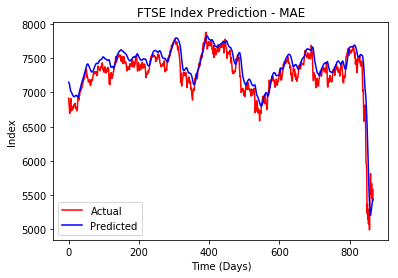

In [74]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Actual')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted')
plt.title('FTSE Index Prediction - MAE')
plt.xlabel('Time (Days)')
plt.ylabel('Index')
plt.legend()
#plt.xlim(0,100)
plt.show()

In [75]:
# MSE (mean squared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

174.07560307896162


In [76]:
# MAE (mean absolute error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

123.76650199362759


In [80]:
# evaluate model by reducing the batch size to 64

batch_size = 64

In [81]:
# Determine training set size - ie. modulo zero, given batch_size 64 as starting point (TO BE ITERATED)

def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))


length = get_train_length(df_data_3, batch_size, 0.1)
print(length)

8320
8384
8384


In [82]:
# Add timesteps * 2
# Use 14 timesteps - will provide a FORTNIGHT window of historic data on which to predict the following fortnight
# Create a single feature dataset for training

timesteps = 14

upper_train = length + timesteps*2
df_data_3_train = df_data_3[0:upper_train]
training_set = df_data_3_train.iloc[:,1:2].values
training_set.shape

(8412, 1)

In [83]:
# Feature Scaling - between zero to 1

from sklearn.preprocessing import MinMaxScaler
import numpy as np

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(8412, 1)

In [84]:
# Create training set arrays

X_train = []
y_train = []

# Data structure with 14 timesteps

print(length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
#create X_train matrix
#14 items per array (timestep) 
print(X_train[0:2])
print(np.array(X_train).shape)
#create Y_train matrix
#14 items per array (timestep) 
print(y_train[0:2])
print(np.array(y_train).shape)

8398
8384
8384
[array([0.00168107, 0.00185552, 0.0045833 , 0.00667671, 0.00756482,
       0.00751725, 0.0057886 , 0.00704147, 0.00884942, 0.00937277,
       0.00872254, 0.01138688, 0.01124415, 0.01143446]), array([0.00185552, 0.0045833 , 0.00667671, 0.00756482, 0.00751725,
       0.0057886 , 0.00704147, 0.00884942, 0.00937277, 0.00872254,
       0.01138688, 0.01124415, 0.01143446, 0.00949964])]
(8384, 14)
[array([0.00949964, 0.01083181, 0.01373404, 0.01351201, 0.01411466,
       0.01295694, 0.01206883, 0.01164063, 0.01013401, 0.01156134,
       0.00813575, 0.00551899, 0.00678773, 0.00475775]), array([0.01083181, 0.01373404, 0.01351201, 0.01411466, 0.01295694,
       0.01206883, 0.01164063, 0.01013401, 0.01156134, 0.00813575,
       0.00551899, 0.00678773, 0.00475775, 0.0049322 ])]
(8384, 14)


In [85]:
# Function to determine test set -  - ie. modulo zero, given batch_size 64 as starting point (TO BE ITERATED)

def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [86]:
# Reshape to Tensor for model input

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(8384, 14, 1)
(8384, 14, 1)


In [87]:
# Establish test set size

test_length = get_test_length(df_data_3, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

9180
9244
9244
832


In [88]:
print(upper_train, upper_test, len(df_data_3))

8412 9272 9317


In [89]:
# Create test set array using same steps as for training set

# Subset
df_data_3_test = df_data_3[upper_train:upper_test] 
test_set = df_data_3_test.iloc[:,1:2].values

# Normalize
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

# Create input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


# Reshape to Tensor
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [90]:
X_test.shape

(832, 14, 1)

In [91]:
# Initialise the LSTM Model v2 with MAE Loss-Function, using Functional API, Batch Size 64

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(nodes, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(nodes, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# Use 'adam' initially, but iterate over others

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (64, 14, 1)               0         
_________________________________________________________________
lstm_5 (LSTM)                (64, 14, 10)              480       
_________________________________________________________________
lstm_6 (LSTM)                (64, 14, 10)              840       
_________________________________________________________________
dense_3 (Dense)              (64, 14, 1)               11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [92]:
# Run model

for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
8384/8384 [==============================] - 682s 81ms/step - loss: 0.0614
Epoch: 1
Epoch 1/1
8384/8384 [==============================] - 687s 82ms/step - loss: 0.0907
Epoch: 2
Epoch 1/1
8384/8384 [==============================] - 726s 87ms/step - loss: 0.0655
Epoch: 3
Epoch 1/1
8384/8384 [==============================] - 672s 80ms/step - loss: 0.0562
Epoch: 4
Epoch 1/1
8384/8384 [==============================] - 693s 83ms/step - loss: 0.0466
Epoch: 5
Epoch 1/1
8384/8384 [==============================] - 676s 81ms/step - loss: 0.0478
Epoch: 6
Epoch 1/1
8384/8384 [==============================] - 683s 82ms/step - loss: 0.0425
Epoch: 7
Epoch 1/1
8384/8384 [==============================] - 676s 81ms/step - loss: 0.0452
Epoch: 8
Epoch 1/1
8384/8384 [==============================] - 683s 82ms/step - loss: 0.0400
Epoch: 9
Epoch 1/1
8384/8384 [==============================] - 697s 83ms/step - loss: 0.0422


In [93]:
# Prediction

predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(832, 14, 1)
(832, 14)
(818, 1)


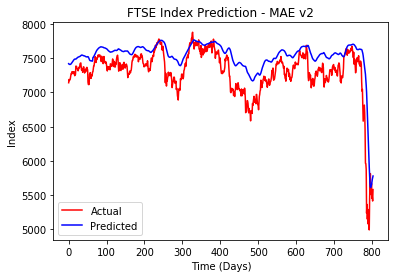

In [94]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Actual')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted')
plt.title('FTSE Index Prediction - MAE v2')
plt.xlabel('Time (Days)')
plt.ylabel('Index')
plt.legend()
#plt.xlim(0,100)
plt.show()

In [95]:
# MSE (mean squared error)

rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

299.2492261917278


In [96]:
# MAE (mean absolut error)

mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

235.2814229633085


In [100]:
# Mean value of testset

predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


pred_mae = []

for j in range(0, testset_length - timesteps):
    pred_mae = np.append(pred_mae, predicted_bcg_values_test_mae[j, timesteps-1])

pred_mae = np.reshape(pred_mae, (pred_mae.shape[0], 1))


mean = np.mean(np.float64(test_set[timesteps:len(pred_mae)]))
print(mean)

7295.700248756219


In [101]:
# NMSE (Normalized MSE)

nrmse = (rmse / mean)*100
print(nrmse)

4.101720410494445


In [102]:
# NMAE (Normalized MAE)

nmae = (mae / mean)*100
print (nmae)

3.2249326992761196


In [113]:
# Initialise the LSTM Model with MSE Loss-Function, using Functional API, Batch Size 128 (as per MAE v1 model)

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mse = LSTM(nodes, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(nodes, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 1)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

# Use 'adam' initially

regressor_mse.compile(optimizer='adam', loss = 'mse')
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (128, 14, 1)              0         
_________________________________________________________________
lstm_7 (LSTM)                (128, 14, 10)             480       
_________________________________________________________________
lstm_8 (LSTM)                (128, 14, 10)             840       
_________________________________________________________________
dense_4 (Dense)              (128, 14, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Run model

for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
8320/8320 [==============================] - 353s 42ms/step - loss: 0.0100
Epoch: 1
Epoch 1/1
8320/8320 [==============================] - 346s 42ms/step - loss: 0.0158
Epoch: 2
Epoch 1/1
8320/8320 [==============================] - 339s 41ms/step - loss: 0.0050
Epoch: 3
Epoch 1/1
8320/8320 [==============================] - 336s 40ms/step - loss: 0.0039
Epoch: 4
Epoch 1/1
8320/8320 [==============================] - 348s 42ms/step - loss: 0.0037
Epoch: 5
Epoch 1/1
8320/8320 [==============================] - 349s 42ms/step - loss: 0.0036
Epoch: 6
Epoch 1/1
8320/8320 [==============================] - 353s 42ms/step - loss: 0.0035
Epoch: 7
Epoch 1/1
8320/8320 [==============================] - 322s 39ms/step - loss: 0.0034
Epoch: 8
Epoch 1/1
8320/8320 [==============================] - 368s 44ms/step - loss: 0.0033
Epoch: 9
Epoch 1/1
8320/8320 [==============================] - 361s 43ms/step - loss: 0.0032


In [118]:
# Prediction

predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

In [143]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))

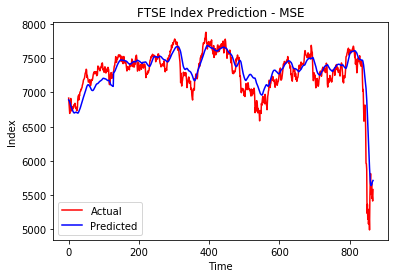

In [144]:
# Visualising the results
plt.plot(test_set[timesteps:len(pred_mse)].astype(float), color = 'red', label = 'Actual')
plt.plot(pred_mse[0:len(pred_mse) - timesteps], color = 'blue', label = 'Predicted')
plt.title('FTSE Index Prediction - MSE')
plt.xlabel('Time')
plt.ylabel('Index')
plt.legend()
plt.show()

In [133]:
# MSE (mean squared error)

rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

423.14924152691134


In [134]:
# MAE (mean absolute error)

mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

324.15230803987873


In [135]:
# Mean value of testset

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (predicted_bcg_values_test_mse.shape[0], 
                                        predicted_bcg_values_test_mse.shape[1]))
predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)


pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (pred_mse.shape[0], 1))


mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print(mean)

7273.252534562211


In [136]:
# NMSE (Normalized MSE)

nrmse = (rmse / mean)*100
print(nrmse)

5.817881883189436


In [137]:
# NMAE (Normalized MAE)

nmae = (mae / mean)*100
print (nmae)

4.456772351840111


In [145]:
# Final permutation of hyperparameters, initialise MAE model with 20 epochs and batch_size 128

epochs = 20

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
lstm_1_mae = LSTM(nodes, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(nodes, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

# Use 'adam' initially

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (128, 14, 1)              0         
_________________________________________________________________
lstm_9 (LSTM)                (128, 14, 10)             480       
_________________________________________________________________
lstm_10 (LSTM)               (128, 14, 10)             840       
_________________________________________________________________
dense_5 (Dense)              (128, 14, 1)              11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [146]:
# Run model

for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
8320/8320 [==============================] - 351s 42ms/step - loss: 0.1694
Epoch: 1
Epoch 1/1
8320/8320 [==============================] - 345s 42ms/step - loss: 0.1652
Epoch: 2
Epoch 1/1
8320/8320 [==============================] - 314s 38ms/step - loss: 0.0933
Epoch: 3
Epoch 1/1
8320/8320 [==============================] - 346s 42ms/step - loss: 0.0492
Epoch: 4
Epoch 1/1
8320/8320 [==============================] - 338s 41ms/step - loss: 0.0507
Epoch: 5
Epoch 1/1
8320/8320 [==============================] - 345s 41ms/step - loss: 0.0460
Epoch: 6
Epoch 1/1
8320/8320 [==============================] - 381s 46ms/step - loss: 0.0427
Epoch: 7
Epoch 1/1
8320/8320 [==============================] - 355s 43ms/step - loss: 0.0424
Epoch: 8
Epoch 1/1
8320/8320 [==============================] - 361s 43ms/step - loss: 0.0419
Epoch: 9
Epoch 1/1
8320/8320 [==============================] - 346s 42ms/step - loss: 0.0405
Epoch: 10
Epoch 1/1
8320/8320 [=============================

In [147]:
# Prediction

predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(896, 14, 1)
(896, 14)
(882, 1)


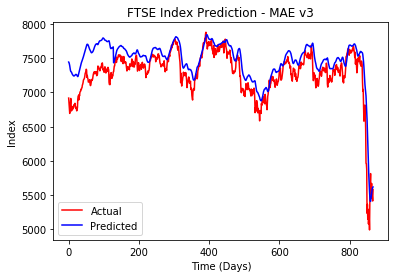

In [148]:
# Visualising the results
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'red', label = 'Actual')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'blue', label = 'Predicted')
plt.title('FTSE Index Prediction - MAE v3')
plt.xlabel('Time (Days)')
plt.ylabel('Index')
plt.legend()
#plt.xlim(0,100)
plt.show()

In [149]:
# MSE (mean sqared error)
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps]))
print(rmse)

252.96098298184552


In [150]:
# MAE (mean absolute error)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(y_test)], y_test[0:len(y_test) - timesteps])
print(mae)

196.39021108600954


In [151]:
# NMSE (Normalized MSE)

nrmse = (rmse / mean)*100
print(nrmse)

3.4779623253803558


In [166]:
# NMAE (Normalized MAE)

nmae = (mae / mean)*100
print (nmae)

2.7001703866704885


***

## Selection / Final Result

#### <font color=red> The optimal configuration, within the computational limits of this project is: MAE, Batch Size 128, 10 Epochs